In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
thedir = '/glade/scratch/djk2120/mini_ens/'
f = 'miniens_oaat'+'0001'+'_h0.nc'

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=12,
                     processes=12, memory="300GB",
                     project='P93300041',
                     walltime='2:00:00')
cluster.scale(12)
client = Client(cluster)

In [2]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=36,
                     processes=36, memory="109GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=5:ncpus=36:mem=109G',
                     walltime='01:00:00')
cluster.scale(36)
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.10.15:39211 Dashboard: http://10.148.10.15:8787/status,Cluster Workers: 36 Cores: 36 Memory: 109.08 GB


In [6]:
ens = range(33)
thedir = '/glade/scratch/djk2120/mini_ens/output/'
paths = [thedir+'miniens_oaat'+str(ee).zfill(4)+'_h1.nc' for ee in ens]


In [7]:
%time ds = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',parallel='True')
ds['ens']=ens
pft = ds['pfts1d_itype_veg'][0]
pftnames = ['BG','NEMT','NEBT','NDBT','BETT','BEMT','BDTT','BDMT','BDBT','BES','BDMS','BDBS','C3ArG','C3G','C4G','C3C']
print(str(np.round(ds.nbytes/1e9,2))+' GB')

CPU times: user 1.19 s, sys: 17.9 ms, total: 1.2 s
Wall time: 2.53 s
0.29 GB


In [14]:
kmax = [2e-8/2**x for x in np.arange(7)]

In [8]:
pdir = '/glade/scratch/djk2120/mini_ens/paramfiles/'
paths = sorted(glob.glob(pdir+'*.nc'))
%time params = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',parallel='True')
ds['ens']=ens

CPU times: user 4.89 s, sys: 238 ms, total: 5.13 s
Wall time: 6.53 s


In [22]:
rset = []
for ee in ens:
    krun = np.unique(params['rootprof_beta'].sel(ens=ee))
    if krun.size==1:
        rset.append(ee)
rpb = params['rootprof_beta'].sel(ens=kset).groupby('ens').mean(dim=xr.ALL_DIMS)

In [56]:
rpb = np.array([params['rootprof_beta'].sel(ens=ee)[0,4].values for ee in ens])
ix = rpb!=rpb[0]
rpb = rpb[ix]
rset = np.array(ens)[ix]

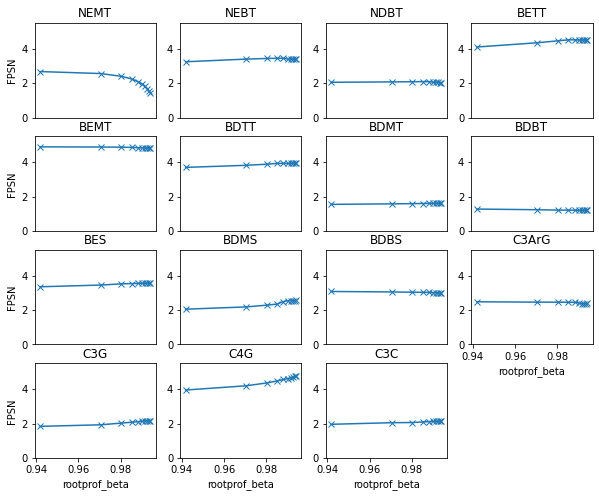

In [59]:
plt.figure(figsize=[10,8])
for ixpft in 1+np.arange(15):
    f = [np.mean(ds['FPSN'].sel(ens=ee)[:,pft==ixpft]) for ee in rset]
    plt.subplot(4,4,ixpft)
    plt.plot(rpb,f,'-x')
    #plt.plot([params['krmax'].sel(ens=0)[ixpft],params['krmax'].sel(ens=0)[ixpft]],[0,6],'r:')
    if (ixpft>11):
        plt.xlabel('rootprof_beta')
    else:
        plt.xticks([])
    if (ixpft==1)|(ixpft==5)|(ixpft==9)|(ixpft==13):
        plt.ylabel('FPSN')
    plt.ylim([0,5.5])
    #plt.xlim([-2.5e-9,2.5e-8])
    plt.title(pftnames[ixpft])

In [9]:
kset = []
for ee in ens:
    krun = np.unique(params['krmax'].sel(ens=ee))
    if krun.size==1:
        kset.append(ee)
krmax = params['krmax'].sel(ens=kset)[:,2]

In [52]:
kr_table = pd.DataFrame()
kr_table['name']=pftnames
kr_table['Krmax']=params['krmax'].sel(ens=0)[:16].values
kr_table

,name,Krmax
0,BG,0.000000e+00
1,NEMT,1.000000e-11
2,NEBT,1.995262e-10
3,NDBT,3.162278e-10
4,BETT,6.309573e-09
5,BEMT,3.981072e-09
6,BDTT,7.943282e-09
7,BDMT,3.981072e-09
8,BDBT,1.995262e-08
9,BES,1.995262e-10


distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-c63770c3bcd34cb40d3964424e8b0433',)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-c63770c3bcd34cb40d3964424e8b0433',)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-a71da46698be9727d73376c11629fa27',)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-a71da46698be9727d73376c11629fa27',)
NoneType: None
distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-ff9e327fdca4d125c5e324c791c58ef1',)": []} state: ['waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-ff9e327fdca4d125c5e324c791c58ef1',)
NoneType: None


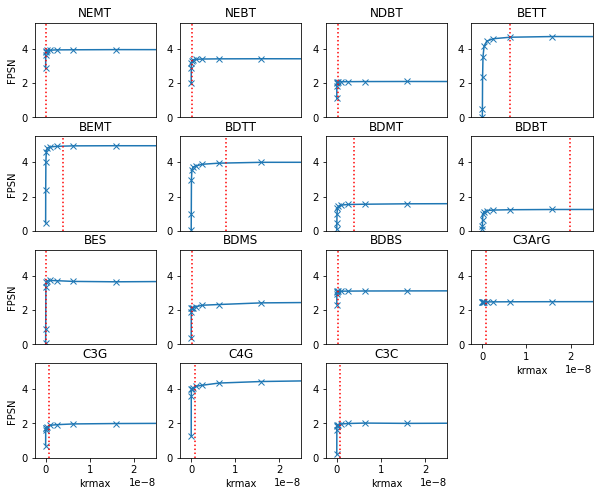

In [56]:
plt.figure(figsize=[10,8])
for ixpft in 1+np.arange(15):
    f = [np.mean(ds['FPSN'].sel(ens=ee)[:,pft==ixpft]) for ee in kset]
    plt.subplot(4,4,ixpft)
    plt.plot(krmax,f,'-x')
    plt.plot([params['krmax'].sel(ens=0)[ixpft],params['krmax'].sel(ens=0)[ixpft]],[0,6],'r:')
    if (ixpft>11):
        plt.xlabel('krmax')
    else:
        plt.xticks([])
    if (ixpft==1)|(ixpft==5)|(ixpft==9)|(ixpft==13):
        plt.ylabel('FPSN')
    plt.ylim([0,5.5])
    plt.xlim([-2.5e-9,2.5e-8])
    plt.title(pftnames[ixpft])

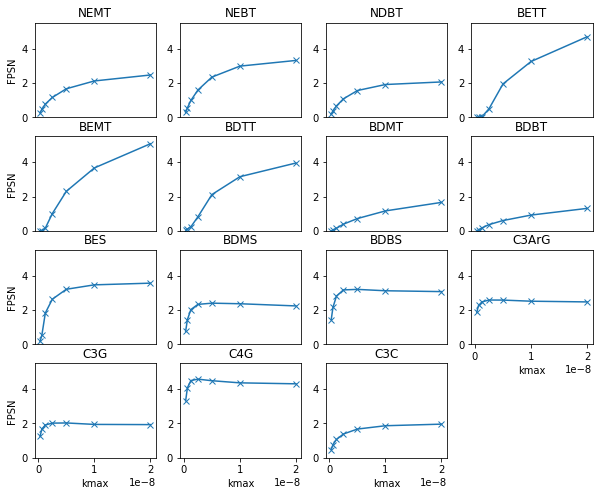

In [15]:
plt.figure(figsize=[10,8])
for ixpft in 1+np.arange(15):
    f = [np.mean(ds['FPSN'].sel(ens=ee)[:,pft==ixpft]) for ee in range(7)]
    plt.subplot(4,4,ixpft)
    plt.plot(kmax,f,'-x')
    if (ixpft>11):
        plt.xlabel('kmax')
    else:
        plt.xticks([])
    if (ixpft==1)|(ixpft==5)|(ixpft==9)|(ixpft==13):
        plt.ylabel('FPSN')
    plt.ylim([0,5.5])
    plt.title(pftnames[ixpft])

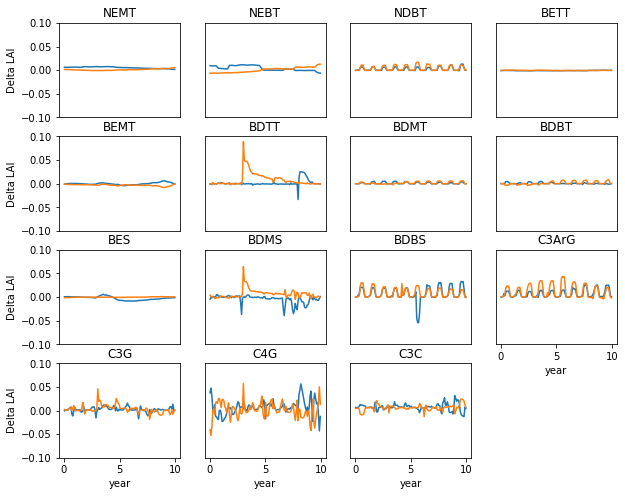

In [69]:
plt.figure(figsize=[10,8])
for ixpft in 1+np.arange(15):
    plt.subplot(4,4,ixpft)
    gpp=np.mean(ds['TLAI'].sel(ens=1)[:,pft==ixpft].values,axis=1)
    ix1 = np.arange(120)
    ix2 = 120+ix1
    ix3 = 120+ix2
    plt.plot((0.5+np.arange(120))/12,(gpp[ix2]-gpp[ix1]))
    plt.plot((0.5+np.arange(120))/12,(gpp[ix3]-gpp[ix2]))
    plt.ylim([-0.1,0.1])
    if (ixpft==1)|(ixpft==5)|(ixpft==9)|(ixpft==13):
        plt.ylabel('Delta LAI')
    else:
        plt.yticks([])
    if (ixpft>11):
        plt.xlabel('year')
    else:
        plt.xticks([])
    plt.title(pftnames[ixpft])


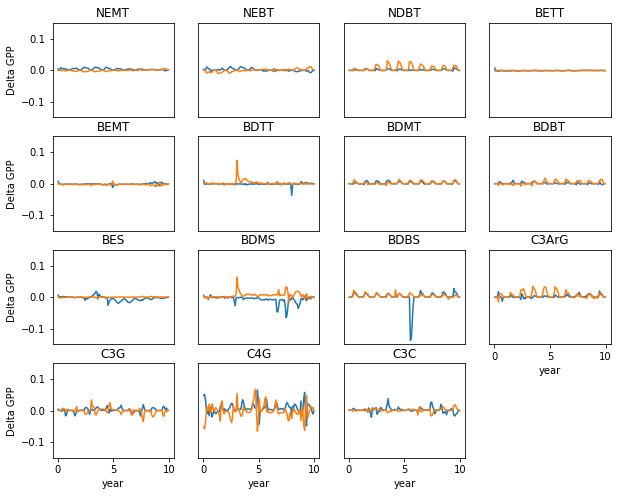

In [68]:
plt.figure(figsize=[10,8])
for ixpft in 1+np.arange(15):
    plt.subplot(4,4,ixpft)
    gpp=np.mean(ds['FPSN'].sel(ens=1)[:,pft==ixpft].values,axis=1)
    ix1 = np.arange(120)
    ix2 = 120+ix1
    ix3 = 120+ix2
    plt.plot((0.5+np.arange(120))/12,(gpp[ix2]-gpp[ix1]))
    plt.plot((0.5+np.arange(120))/12,(gpp[ix3]-gpp[ix2]))
    plt.ylim([-0.15,0.15])
    if (ixpft==1)|(ixpft==5)|(ixpft==9)|(ixpft==13):
        plt.ylabel('Delta GPP')
    else:
        plt.yticks([])
    if (ixpft>11):
        plt.xlabel('year')
    else:
        plt.xticks([])
    plt.title(pftnames[ixpft])


In [72]:
ens = range(13)
thedir = '/glade/scratch/djk2120/mini_ens/output/'
paths = [thedir+'miniens_oaat'+str(ee).zfill(4)+'_h0.nc' for ee in ens]

In [73]:
%time ds2 = xr.open_mfdataset(paths,combine='nested',concat_dim='ens',parallel='True')
ds2['ens']=ens

CPU times: user 3.66 s, sys: 63 ms, total: 3.72 s
Wall time: 5.65 s


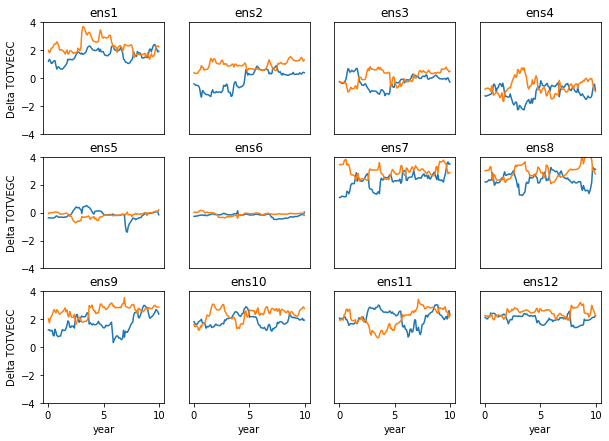

In [96]:

ix1 = np.arange(120)
ix2 = 120+ix1
ix3 = 120+ix2

plt.figure(figsize=[10,7])
for i in 1+np.arange(12):
    tvc = np.mean(ds2['TOTVEGC'].sel(ens=i),axis=1).values
    plt.subplot(3,4,i)
    plt.plot((0.5+np.arange(120))/12,tvc[ix2]-tvc[ix1])
    plt.plot((0.5+np.arange(120))/12,tvc[ix3]-tvc[ix2])
    plt.ylim([-4,4])
    if i>8:
        plt.xlabel('year')
    else:
        plt.xticks([])
    plt.title('ens'+str(i))
    if (i==1)|(i==5)|(i==9):
        plt.ylabel('Delta TOTVEGC')
    else:
        plt.yticks([])




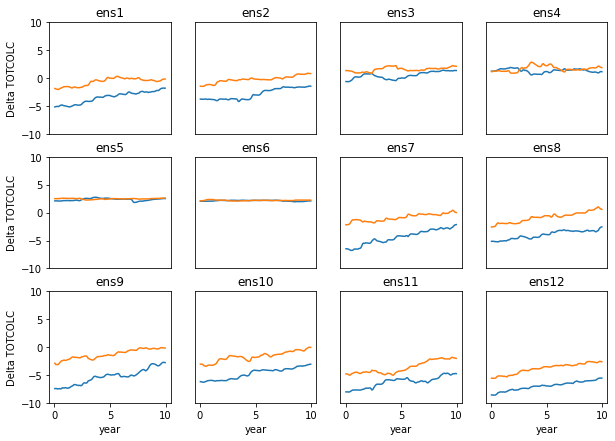

In [101]:
ix1 = np.arange(120)
ix2 = 120+ix1
ix3 = 120+ix2

plt.figure(figsize=[10,7])
for i in 1+np.arange(12):
    tvc = np.mean(ds2['TOTCOLC'].sel(ens=i),axis=1).values
    plt.subplot(3,4,i)
    plt.plot((0.5+np.arange(120))/12,tvc[ix2]-tvc[ix1])
    plt.plot((0.5+np.arange(120))/12,tvc[ix3]-tvc[ix2])
    plt.ylim([-10,10])
    if i>8:
        plt.xlabel('year')
    else:
        plt.xticks([])
    plt.title('ens'+str(i))
    if (i==1)|(i==5)|(i==9):
        plt.ylabel('Delta TOTCOLC')
    else:
        plt.yticks([])

In [102]:
client.close()